In [1]:
import csv
import re
import os
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from time import perf_counter
from io import StringIO
import random
import tqdm

%matplotlib inline

In [2]:
# Use to measure execution of a given block of code:
# with catchtime():
#   # code here
class catchtime:
    def __enter__(self):
        self.start = perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = perf_counter() - self.start
        self.readout = f'Time: {self.time:.3f} seconds'
        print(self.readout)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
sentences = []
with open("jp_en_sentences.tsv", 'r', encoding='utf-8-sig') as f:
    raw = f.read()
    raw = raw.replace("”", "\"")
    raw = raw.replace("“", "\"")
    rd = csv.DictReader(StringIO(raw), delimiter="\t")
    for row in rd:
        sentences.append((row['jp'], row['en']))
jp = [jp for jp, _ in sentences]
en = [en for _, en in sentences]


In [5]:
print("num sentence pairs: ", len(sentences))

num sentence pairs:  264482


In [6]:
block_size = 520
BOS = "BOS"
EOS = "EOS"
jp_chars = sorted(list(set("".join([jp for jp, en in sentences]))))
jp_vocab_size = len(jp_chars)
jp_stoi = { ch:i for i,ch in enumerate(jp_chars) }
jp_stoi[EOS] = len(jp_stoi)
jp_stoi[BOS] = len(jp_stoi)
jp_itos = { i:ch for i,ch in enumerate(jp_chars) }
jp_itos[len(jp_stoi)-2] = EOS
jp_itos[len(jp_stoi)-1] = BOS

JP_VOCAB_SIZE = len(jp_stoi)


def encode_jp(sent):
    enc = [jp_stoi[BOS]] + [jp_stoi[c] for i, c in enumerate(sent)]
    enc += [jp_stoi[EOS]] * (block_size - len(enc))
    return enc
def decode_jp(encoded):
    return "".join([jp_itos[c] for c in encoded])

In [7]:
decode_jp(encode_jp(sentences[0][0]))

'BOSきみにちょっとしたものをもってきたよ。EOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEO

In [8]:
class LinkedListIter:
    def __init__(self, head):
        self.head = head
    def __next__(self):
        if not self.head:
            raise StopIteration
        curr = self.head
        self.head = self.head.next
        return curr

class LinkedList:
    def __init__(self, contents):
        self.contents = contents
        self.next = None
        self.cached_full = None

    @staticmethod
    def create(chunk):
        curr = None
        head = None
        for c in chunk:
            new = LinkedList(c)
            if curr:
                curr.next = new
            else:
                head = new
            curr = new
        head.cached_full = chunk
        return head
    def merge(self):
        assert self.next
        self.contents += self.next.contents
        self.next = self.next.next

    def __iter__(self):
        return LinkedListIter(self)
    def __repr__(self):
        return f"LL{{{self.contents}, {self.next}}}"


In [9]:
def count_bigrams(chunks, weights):
    counter = collections.Counter()
    for chunk_i in range(len(chunks)):
        chunk = chunks[chunk_i]
        if not chunk.next:
            continue
        for c1, c2 in zip(chunk, chunk.next):
            counter[(c1.contents, c2.contents)] += weights[chunk.cached_full]
    return counter            
        
def merge(chunks, bigram, cnts, weights):
    cnts[bigram] = 0
    for chunk in chunks:
        head = chunk
        prev = None
        while head:
            if not head.next:
                break
            c1, c2 = head.contents, head.next.contents
            if (c1, c2) == bigram:
                head.merge()
                if prev:
                    cnts[(prev.contents, head.contents)] += weights[chunk.cached_full]
                if head.next:
                    cnts[(head.contents, head.next.contents)] += weights[chunk.cached_full]
            prev = head
            head = head.next

def seed_merges(sentences):
    out = {}
    for sent in sentences:
        for c in sent:
            if c not in out:
                out[c] = len(out)
    return out

def count_occurences(splits):
    counter = collections.Counter()
    for sent in splits:
        for chunk in sent:
            counter[chunk] += 1
    return counter

PRE_TOKENIZATION_REGEX = re.compile(r"'s|'t|'re|'ve|'m|'ll|'d| ?\w+|\s|\S")

def bpe(merges, sentences, vocab_size):
    splits = [re.findall(PRE_TOKENIZATION_REGEX, s) for s in sentences]
    weights = count_occurences(splits)
    chunks = list(weights.keys())
    for i in range(len(chunks)):
        chunks[i] = LinkedList.create(chunks[i])
    cnts = count_bigrams(chunks, weights)
    for merge_id in range(vocab_size):
        top = cnts.most_common(1)
        if len(top) == 0:
            return merges
        top = top[0][0]
        merges["".join(top)] = len(merges)
        merge(chunks, top, cnts, weights)
    merges[EOS] = len(merges)
    merges[BOS] = len(merges)
    return merges

def encode_en(sent, merges):
    chunks = re.findall(PRE_TOKENIZATION_REGEX, sent)
    for i in range(len(chunks)):
        chunks[i] = LinkedList.create(chunks[i])
    out = []
    for chunk in chunks:
        head = chunk
        while head:
            if not head.next:
                break
            c1, c2 = head.contents, head.next.contents
            if (c1 + c2) in merges:
                head.merge()
            head = head.next
    out = []
    for chunk in chunks:
        for c in chunk:
            out.append(merges[c.contents])
    out = [merges[BOS]] + out
    out += [merges[EOS]] * (block_size - len(out))
    return out

def decode_en(enc, merges_reversed):
    return "".join(merges_reversed[id] for id in enc)

def print_encoded_chunks(encoded, merges_reversed):
    ",".join(rev[id] for id in enc)

In [10]:
CNT = len(sentences)
with catchtime():
    merges = seed_merges([en for _, en in sentences])
    print(f"Pre BPE size: {len(merges)}")
    merges = bpe(merges, [en for _, en in sentences[:CNT]], 1000)
    merges_reversed = {i: seq for seq, i in merges.items()}
EN_VOCAB_SIZE = len(merges)
print(f"Dict size: {len(merges)}")

Pre BPE size: 147
Time: 22.962 seconds
Dict size: 1149


In [11]:
VALIDATE_ROUNDTRIP = False
with catchtime():
    if VALIDATE_ROUNDTRIP:
        for jp, en in sentences:
            assert (roundtripped := decode_en(encode_en(en, merges), merges_reversed)).startswith("BOS" + en), f"{roundtripped=} {en=}"

Time: 0.000 seconds


In [12]:
# Let's now split up the data into train and validation sets
TEST_SIZE = 100
TRAIN_SIZE = len(sentences) - TEST_SIZE
train_data = sentences[:TRAIN_SIZE]
val_data = sentences[TRAIN_SIZE:]

def tensorify(sentence_pairs, merges):
    jp = [encode_jp(jp) for jp, _ in sentence_pairs]
    en = [encode_en(en, merges) for _, en in sentence_pairs]
    jp_t, en_t = torch.tensor(jp), torch.tensor(en)
    Y_train = torch.zeros_like(en_t)
    Y_train[:, :-1] = en_t[:, 1:]
    Y_train[:, -1] = merges[EOS]
    return jp_t.to(device), en_t.to(device), Y_train.to(device)   

In [13]:
batch_size = 16

def get_train_data():
    pairs = []
    for _ in range(batch_size):
        ix = random.randint(0, TRAIN_SIZE-1)
        pairs.append(train_data[ix])
    return pairs

def get_batch(split, merges):
    # generate a small batch of data of inputs x and targets y
    data = get_train_data() if split == 'train' else val_data
    return tensorify(data, merges)

@torch.no_grad()
def estimate_loss_BROKEN(merges):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

Xjp_test, Xen_test, Y_test = get_batch('test', merges)

In [69]:
n_emb = 64
n_heads = 4
n_layer = 4
learning_rate = 1e-3
dropout = .1

class Head(nn.Module):
    def __init__(self, head_size, masked=True):
        super().__init__()
        self.query = nn.Linear(n_emb, head_size, bias=False)
        self.key = nn.Linear(n_emb, head_size, bias=False)
        self.value = nn.Linear(n_emb, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.masked = masked

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        weight = query @ key.transpose(-2, -1) * C ** -.5

        if self.masked and not self.training:
            weight = weight.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)

        return weight @ value

class CrossHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_emb, head_size, bias=False)
        self.key = nn.Linear(n_emb, head_size, bias=False)
        self.value = nn.Linear(n_emb, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x_dec, x_enc):
        _, _, C = x_enc.shape
        query = self.query(x_dec)
        key = self.key(x_enc)
        value = self.value(x_enc)
        weight = query @ key.transpose(-2, -1) * C ** -.5

        weight = F.softmax(weight, dim=-1)
        weight = self.dropout(weight)

        return weight @ value

class MultiHead(nn.Module):
    def __init__(self, num_heads, head_size, masked=True):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, masked) for _ in range(num_heads)])
        self.proj = nn.Linear(n_emb, n_emb)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class MultiCrossHead(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([CrossHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_emb, n_emb)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x_dec, x_enc):
        out = torch.cat([h(x_dec, x_enc) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FFBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_emb, 4*n_emb),
            nn.ReLU(),
            nn.Linear(4*n_emb, n_emb),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.network(x)

class DecoderBlock(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        assert n_emb % num_heads == 0, f"num_heads should divide n_emb evenly, found {n_emb}%{num_heads} = {n_emb % num_heads}"
        head_size = n_emb // num_heads
        self.att = MultiHead(num_heads, head_size)
        self.cross_attn = MultiCrossHead(num_heads, head_size)
        self.ff = FFBlock()
        self.ln1 = nn.LayerNorm(n_emb)
        self.ln2 = nn.LayerNorm(n_emb)
        self.ln3 = nn.LayerNorm(n_emb)
        
    def forward(self, x, x_enc):
        x = x + self.att(self.ln1(x))
        x = x + self.cross_attn(self.ln2(x), x_enc)
        x = x + self.ff(self.ln3(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        assert n_emb % num_heads == 0, f"num_heads should divide n_emb evenly, found {n_emb}%{num_heads} = {n_emb % num_heads}"
        head_size = n_emb // num_heads
        self.att = MultiHead(num_heads, head_size, masked=False)
        self.ff = FFBlock()
        self.ln1 = nn.LayerNorm(n_emb)
        self.ln2 = nn.LayerNorm(n_emb)
        
    def forward(self, x):
        x = x + self.att(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x
        

class DecoderStack(nn.Module):
    def __init__(self, num_stacks, num_heads):
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock(num_heads=num_heads) for _ in range(n_layer)])

    def forward(self, x_dec, x_enc):
        for layer in self.layers:
            x_dec = layer(x_dec, x_enc)
        return x_dec
            
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.enc_token_embedding_table = nn.Embedding(JP_VOCAB_SIZE, n_emb)
        self.enc_position_embedding_table = nn.Embedding(block_size, n_emb)
        self.dec_token_embedding_table = nn.Embedding(EN_VOCAB_SIZE, n_emb)
        self.dec_position_embedding_table = nn.Embedding(block_size, n_emb)
        self.decoder_blocks = DecoderStack(n_layer, n_heads)
        self.encoder_blocks = nn.Sequential(*[EncoderBlock(num_heads=n_heads) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_emb) # final layer norm
        self.lm_head = nn.Linear(n_emb, EN_VOCAB_SIZE)

    def forward(self, enc_idx, dec_idx, targets=None):
        B, T_enc = enc_idx.shape
        _, T_dec = dec_idx.shape

        # both (B,T_enc) tensor of integers
        enc_tok_emb = self.enc_token_embedding_table(enc_idx) # (B,T_enc,C)
        enc_pos_emb = self.enc_position_embedding_table(torch.arange(T_enc, device=device)) # (T_enc,C)

        x_enc = enc_tok_emb + enc_pos_emb

        y_enc = self.encoder_blocks(x_enc)

        dec_tok_emb = self.dec_token_embedding_table(dec_idx) # (B,T_dec,C)
        dec_pos_emb = self.dec_position_embedding_table(torch.arange(T_dec, device=device)) # (T_dec,C)

        x_dec = dec_tok_emb + dec_pos_emb # (B,T_dec,C)
        # HERE: x_enc -> y_enc
        x = self.decoder_blocks.forward(x_dec, y_enc) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = Model()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

losses=[]
test_losses=[]

0.890109 M parameters


In [70]:
import os
MODEL_PATH = "model.pt"
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH).state_dict())


In [18]:
eval_interval = 20000
max_iters = 100000
start = time.time()
for iter in tqdm.tqdm(range(max_iters)):
    Xjp_train, Xen_train, Y_train = get_batch('train', merges)
    logits, loss = m(Xjp_train, Xen_train, Y_train)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        #_, test_loss = m(Xjp_test, Xen_test, Y_test)
        #test_losses.append(test_loss.item())
        #print(f"step {iter} elapsed {time.time() - start:.0f}s: train: {loss.item():.4f} test: {test_loss.item():.4f}")
        test_losses.append(loss.item())
        print(f"step {iter} elapsed {time.time() - start:.0f}s: train: {loss.item():.4f}")
    else:
        test_losses.append(test_losses[-1])


  0%|          | 2/100000 [00:00<6:57:36,  3.99it/s] 

step 0 elapsed 0s: train: 0.1512


 20%|██        | 20002/100000 [54:10<3:37:00,  6.14it/s]

step 20000 elapsed 3250s: train: 0.0582


 40%|████      | 40002/100000 [1:48:09<2:41:45,  6.18it/s]

step 40000 elapsed 6489s: train: 0.0571


 60%|██████    | 60002/100000 [2:42:21<1:47:54,  6.18it/s]

step 60000 elapsed 9741s: train: 0.0703


 80%|████████  | 80002/100000 [3:36:19<53:56,  6.18it/s]  

step 80000 elapsed 12980s: train: 0.0641


100%|██████████| 100000/100000 [4:30:16<00:00,  6.17it/s]

step 99999 elapsed 16217s: train: 0.0759


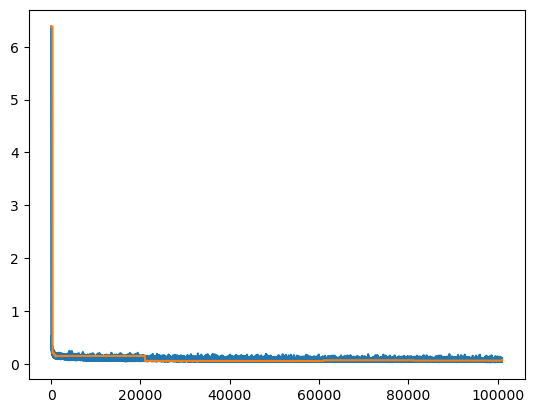

In [19]:
plt.plot(losses)
plt.plot(test_losses)
plt.show()

In [75]:
def generate_response(jp, merges, generator):
    assert jp.shape[0] == 1
    model.eval()
    idx = torch.zeros((1,1), dtype=torch.long, device=device)
    idx += merges[BOS]
    # idx is (B, T) array of indices in the current context
    for _ in range(block_size):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = model(jp, idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1, generator=generator) # (B, 1)
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        if idx_next[0][0].item() == merges[EOS]:
            break
    model.train()
    return idx

def translate(jp, expected=None, generator=None):
    encoded_jp = encode_jp(jp)
    translated = decode_en(generate_response(torch.tensor([encoded_jp], device=device), merges, generator).tolist()[0], merges_reversed)
    s = f"input=\"{jp}\"\n{translated=}\n"
    if expected:
        s += f"{expected=}"
    return s
start = 30
n = 10
g = torch.Generator(device=device)
g.manual_seed(0)
for i in range(n):
    print(translate(sentences[start + i][0], sentences[start + i][1], g))
    print()

input="私は一日に100ユーロ稼ぎます。"
translated='BOSI enjoy 100 usual days in ten days.EOS'
expected='I make €100 a day.'

input="私は一日に100ユーロ稼ぎます。"
translated='BOSI am to earn to earnest under a day.EOS'
expected='I make 100 euros per day.'

input="すぐに諦めて昼寝をするかも知れない。"
translated='BOSWe want to keep to sleep on your day after lunch.EOS'
expected='I may give up soon and just nap instead.'

input="すぐに諦めて昼寝をするかも知れない。"
translated='BOSWe may know whether to a right nappo appreciates seat.EOS'
expected='I may give up soon and just take a nap.'

input="それはあなたが一人になりたくないからです。"
translated="BOSIt isn't so well get there an everything.EOS"
expected="It's because you don't want to be alone."

input="それはあなたが一人になりたくないからです。"
translated='BOSThat will be a good person out of you.EOS'
expected="That's because you don't want to be alone."

input="そんなことは起きないでしょう。"
translated="BOSI won't join so so much.EOS"
expected="That won't happen."

input="そんなことは起きないでしょう。"
translated="BOSDon't get it up so that.EOS"
expected="That

In [63]:
translate("こんにちは")

'input="こんにちは"\ntranslated=\'BOSAll.EOS\'\n'